In [1]:
import os
import overpy
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import pandas as pd
import time
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.distance import geodesic
from tqdm import tqdm

Datos de puntos de interés:
- Google Places API: Para obtener información sobre:
    - Restaurantes cercanos
    - Atracciones turísticas
    - Playas
    - Servicios
- OpenStreetMap API: Para datos sobre infraestructuras y puntos de interés
- Distancia a la playa
- Distancia al centro de la ciudad

# 📊 Variables añadidas al dataset `extended`

| Variable | Descripción | Relevancia para el estudio de turismo |
|----------|-------------|---------------------------------------|
| `distancia_ayuntamiento_km` | Distancia (en km) desde cada alojamiento al ayuntamiento del municipio | Proximidad al centro administrativo / centro urbano (acceso a servicios, vida local) |
| `distancia_playa_km` | Distancia (en km) desde cada alojamiento a la playa más cercana | Factor clave para turismo de sol y playa (atractivo principal en Costa Blanca) |
| `distancia_poi_mas_cercano_km` | Distancia (en m) al punto de interés turístico más cercano | Medida de accesibilidad a atracciones culturales / turísticas |
| `distancia_supermercado_mas_cercano_km` | Distancia (en m) al supermercado más cercano | Comodidad para estancias largas / turismo residencial |
| `distancia_parada_bus_mas_cercana_km` | Distancia (en m) a la parada de autobús más cercana | Accesibilidad mediante transporte público, movilidad sin coche |
| `num_pois_2km` | Número de puntos de interés turístico en un radio de 2 km | Densidad de atracciones cercanas (entorno atractivo) |
| `num_supermercados_2km` | Número de supermercados en un radio de 2 km | Acceso a compras de proximidad |
| `num_paradas_bus_2km` | Número de paradas de autobús en un radio de 2 km | Acceso a transporte público local |
| `num_restaurantes_2km` | Número de restaurantes en un radio de 2 km | Oferta gastronómica accesible |


# Carga

In [2]:
data_path = os.path.join(os.getcwd(), 'data')

# monthly = pd.read_csv(os.path.join(data_path, 'Guardamar', 'monthly.csv'))
# extended = pd.read_csv(os.path.join(data_path, 'Guardamar', 'extended.csv'))

monthly = pd.read_csv(os.path.join(data_path, 'monthly.csv'))
extended = pd.read_csv(os.path.join(data_path,'extended.csv'))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21108\1485069488.py:6: DtypeWarning: Columns (24,28) have mixed types. Specify dtype option on import or set low_memory=False.
  monthly = pd.read_csv(os.path.join(data_path, 'monthly.csv'))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21108\1485069488.py:7: DtypeWarning: Columns (51,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  extended = pd.read_csv(os.path.join(data_path,'extended.csv'))


In [3]:
extended.head()

,Property ID,Listing Title,Property Type,Listing Type,Created Date,Last Scraped Date,Country,State,City,Zipcode,...,Integrated Property Manager,Amenities,HomeAway Location Type,Airbnb Property Plus,Airbnb Home Collection,License,Airbnb Property ID,Airbnb Host ID,HomeAway Property ID,HomeAway Property Manager ID
0,ab-295403,A top floor apartment by the sea,Entire apartment,Entire home/apt,2011-12-24,2017-12-19,Spain,NaN,Guardamar del Segura,NaN,...,NaN,"[""kitchen"", ""tv"", ""heating"", ""ac"", ""washer"", ""...",NaN,NaN,NaN,NaN,295403.0,1524447.0,NaN,NaN
1,ab-484366,Beach house 300m from the sea Spain,Home,Entire home/apt,2012-05-16,2023-11-15,Spain,Alicante,Guardamar del Segura,NaN,...,NaN,"[""free_parking"", ""wireless_internet"", ""firepla...",NaN,False,NaN,NaN,484366.0,2397719.0,1204376a,NaN
2,ab-608855,Ven a tomar el sol al Mediterráneo,Apartment,Entire home/apt,2012-07-21,2021-02-09,Spain,Alicante,Guardamar del Segura,NaN,...,NaN,"[""elevator"", ""free_parking"", ""wireless_interne...",NaN,False,NaN,VT-460933-A,608855.0,2760935.0,NaN,NaN
3,ab-627895,NICE APARTMENT IN GUARDAMAR,Rental unit,Entire home/apt,2012-07-30,2023-01-16,Spain,Alicante,Guardamar del Segura,NaN,...,NaN,"[""elevator"", ""kitchen"", ""hangers"", ""iron"", ""wa...",NaN,False,NaN,NaN,627895.0,3086177.0,NaN,NaN
4,ab-719745,Holiday House for rent 150m from Alicante beach,Chalet,Entire home/apt,2012-09-29,2023-11-19,Spain,Alicante,Guardamar del Segura,NaN,...,NaN,"[""fireplace"", ""kitchen"", ""ac"", ""heating"", ""hai...",NaN,False,NaN,NaN,719745.0,2397719.0,NaN,NaN


In [4]:
extended['City'].unique()

array(['Guardamar del Segura', 'Los Montesinos', 'Orihuela',
       'Pilar de la Horadada', 'Rojales', 'San Miguel de Salinas',
       'Torrevieja'], dtype=object)

# Limpieza

In [5]:
def show_nulls(df):
    nulos = df.isnull().sum()

    # Para verlo como porcentaje
    porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

    # Para ver ambos en un DataFrame ordenado por porcentaje de nulos
    resumen_nulos = pd.DataFrame({
        'Valores Nulos': nulos,
        'Porcentaje Nulos': porcentaje_nulos
    }).sort_values('Porcentaje Nulos', ascending=False)

    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Mapa de Calor de Valores Nulos')
    plt.show()
    print(resumen_nulos)

## Monthly

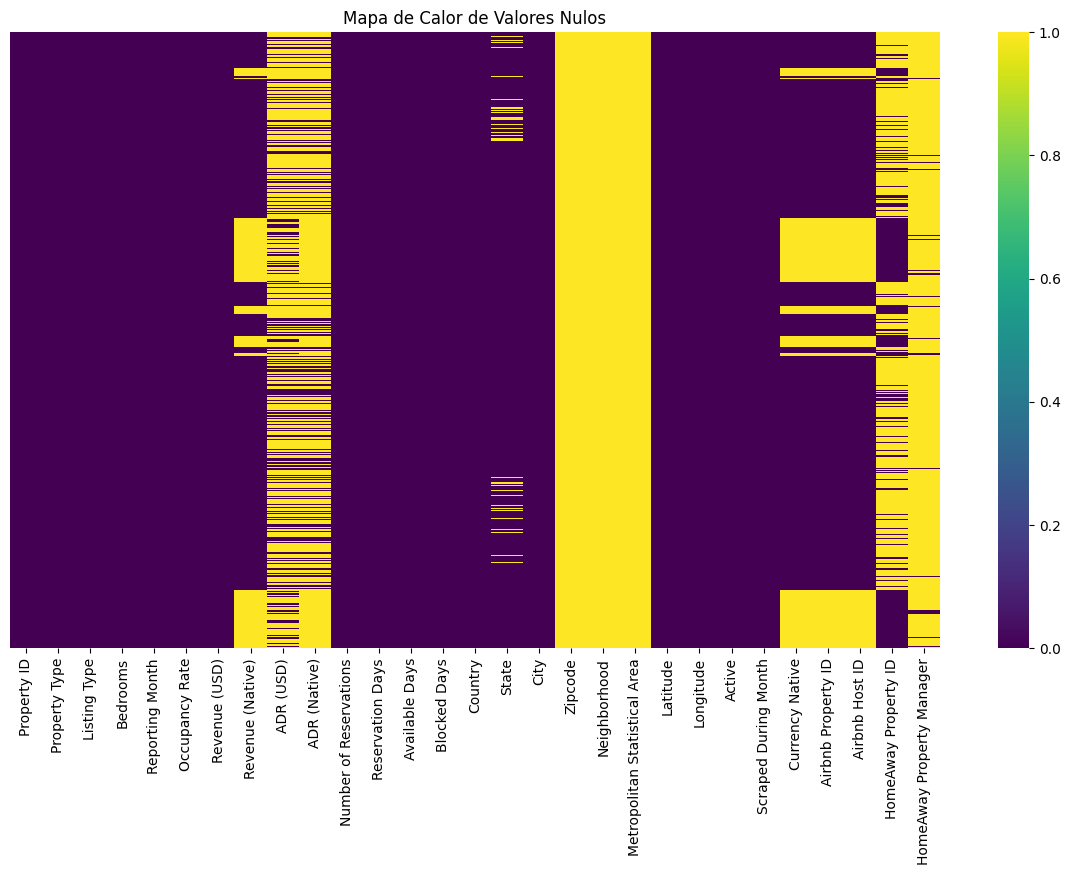

                               Valores Nulos  Porcentaje Nulos
Neighborhood                          950448        100.000000
Metropolitan Statistical Area         950448        100.000000
Zipcode                               950448        100.000000
HomeAway Property Manager             920604         96.860007
ADR (Native)                          709336         74.631753
ADR (USD)                             643541         67.709228
HomeAway Property ID                  584672         61.515412
Airbnb Host ID                        236806         24.915198
Currency Native                       236770         24.911410
Revenue (Native)                      236770         24.911410
Airbnb Property ID                    236758         24.910148
State                                  52112          5.482888
Property Type                            141          0.014835
Listing Type                              48          0.005050
Country                                   12          0

In [6]:
show_nulls(monthly)

In [7]:
drop_columns = [
    'HomeAway Property ID',
    'Airbnb Host ID',
    # 'Airbnb Property ID',
    # 'Property ID'
]

monthly = monthly.dropna(axis=1, how='all')
monthly = monthly.drop(columns=drop_columns) 


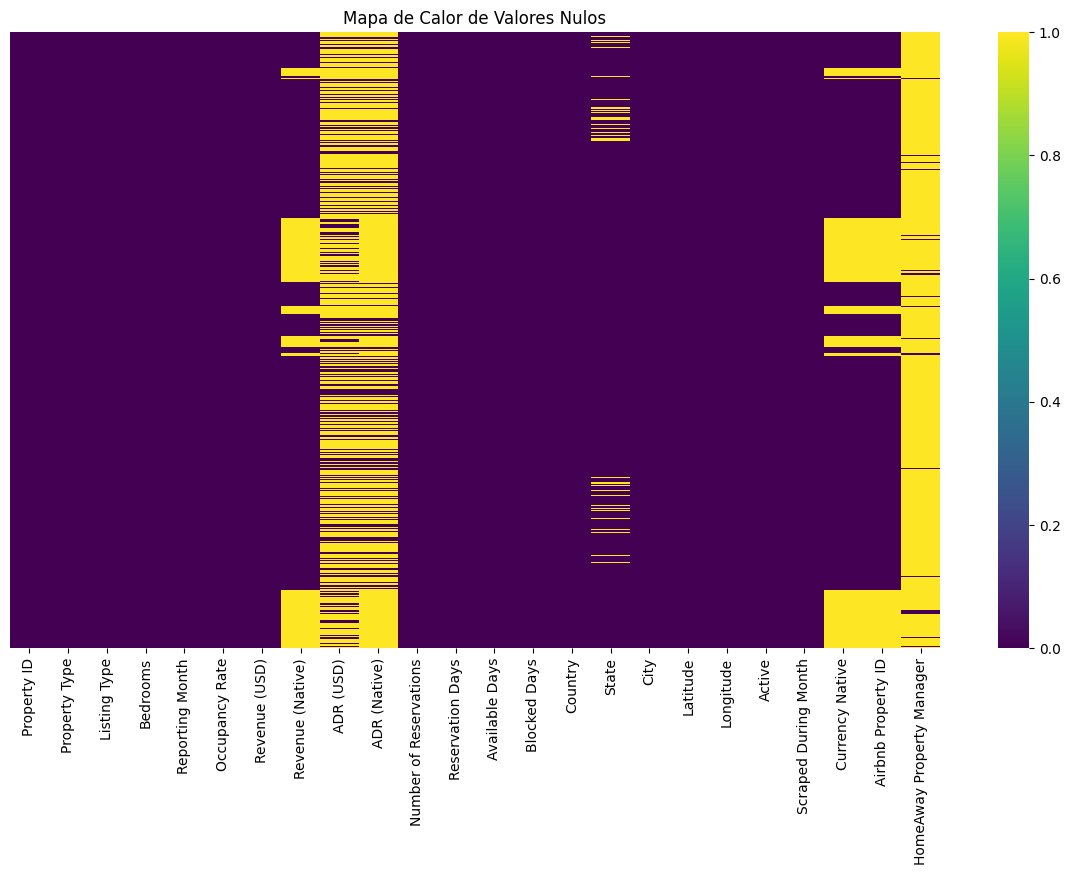

                           Valores Nulos  Porcentaje Nulos
HomeAway Property Manager         920604         96.860007
ADR (Native)                      709336         74.631753
ADR (USD)                         643541         67.709228
Revenue (Native)                  236770         24.911410
Currency Native                   236770         24.911410
Airbnb Property ID                236758         24.910148
State                              52112          5.482888
Property Type                        141          0.014835
Listing Type                          48          0.005050
Country                               12          0.001263
Revenue (USD)                          0          0.000000
Bedrooms                               0          0.000000
Property ID                            0          0.000000
Occupancy Rate                         0          0.000000
Reporting Month                        0          0.000000
Reservation Days                       0          0.0000

In [8]:
show_nulls(monthly)

## Extended

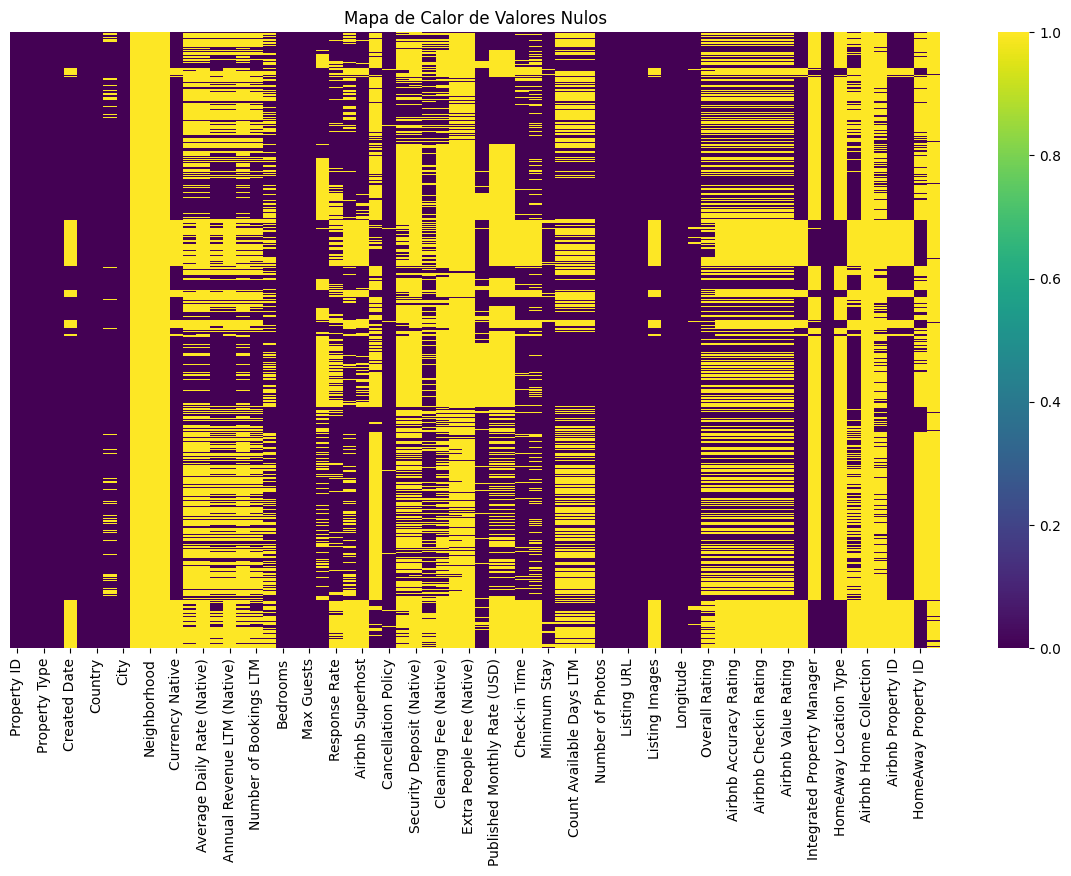

                               Valores Nulos  Porcentaje Nulos
Neighborhood                           31965        100.000000
Zipcode                                31965        100.000000
Airbnb Home Collection                 31965        100.000000
Metropolitan Statistical Area          31965        100.000000
HomeAway Property Manager ID           31159         97.478492
...                                      ...               ...
Instantbook Enabled                        0          0.000000
Longitude                                  0          0.000000
Latitude                                   0          0.000000
Listing URL                                0          0.000000
Amenities                                  0          0.000000

[70 rows x 2 columns]


In [9]:
show_nulls(extended)

In [10]:
drop_columns = [
    'HomeAway Property ID',
    'Airbnb Host ID',
    'HomeAway Property Manager ID'
    # 'Airbnb Property ID',
    # 'Property ID'
]

extended = extended.dropna(axis=1, how='all')
extended = extended.drop(columns=drop_columns) 

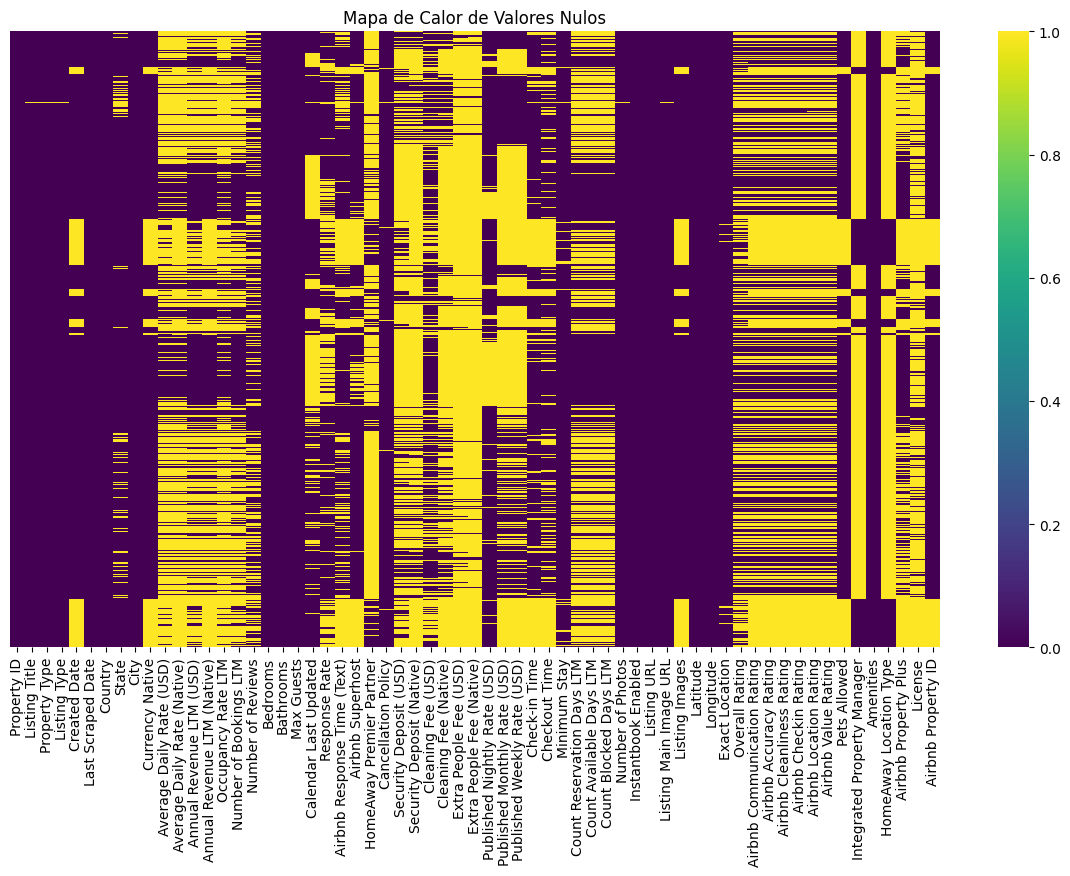

                             Valores Nulos  Porcentaje Nulos
Extra People Fee (Native)            29999         93.849523
Extra People Fee (USD)               29585         92.554356
License                              25907         81.048021
Integrated Property Manager          25902         81.032379
HomeAway Location Type               25844         80.850931
...                                    ...               ...
Instantbook Enabled                      0          0.000000
Latitude                                 0          0.000000
Listing URL                              0          0.000000
Longitude                                0          0.000000
Amenities                                0          0.000000

[63 rows x 2 columns]


In [11]:
show_nulls(extended)

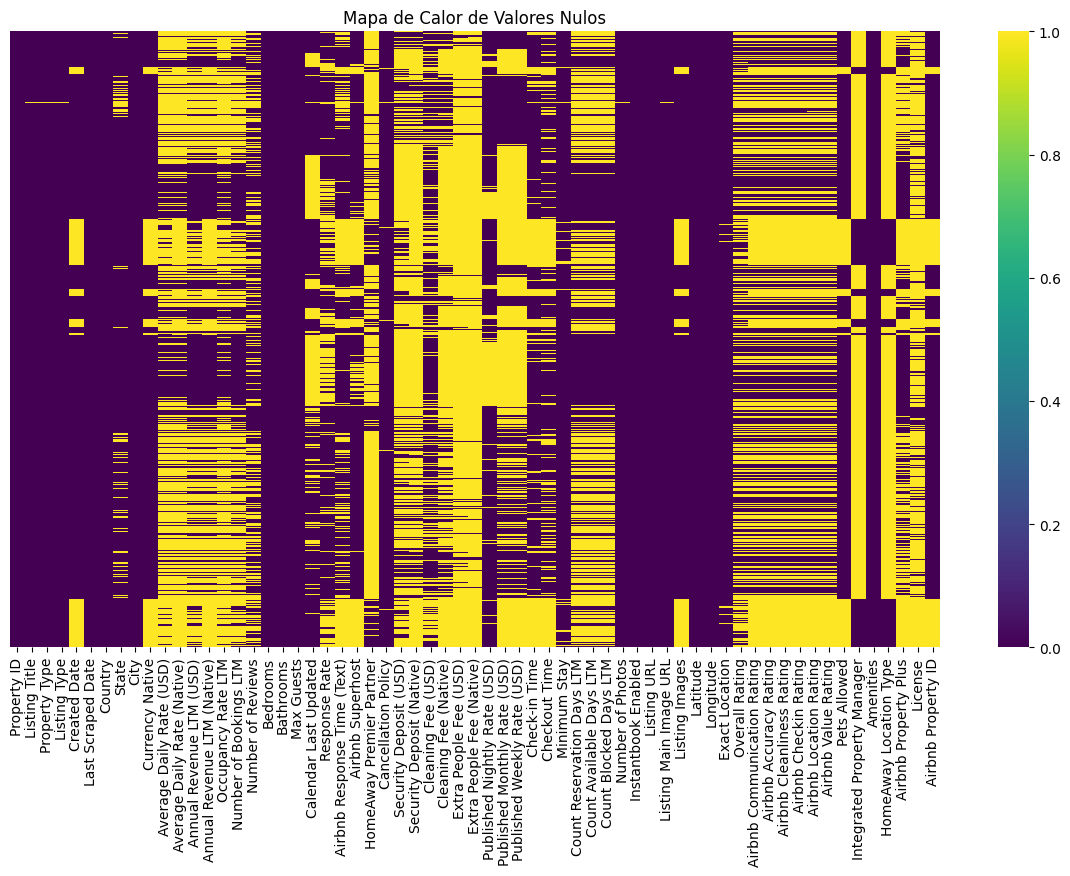

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un mapa de calor de valores nulos
plt.figure(figsize=(15, 8))
sns.heatmap(extended.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Mapa de Calor de Valores Nulos')
plt.show()

# Procesado

In [13]:
def obtener_coordenadas(lugar):
    # URL base de la API de Nominatim
    url = "https://nominatim.openstreetmap.org/search"
    
    # Parámetros de la búsqueda
    params = {
        "q": f"{lugar}",
        "format": "json",
        "limit": 5,
        'countrycodes': 'es'
    }
    
    # Añadir un User-Agent es requerido por la política de uso
    headers = {
        "User-Agent": "mdd_turismo"
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        resultados = response.json()
        if resultados:
            coordenadas = [(float(r['lat']), float(r['lon'])) for r in resultados]
            return coordenadas
        else:
            print(f"No se encontró: {lugar}")
            return None
    else:
        print(f"Error {response.status_code} buscando '{lugar}'")
        return None
    
def obtener_playa_referencia(ciudad):
    # Diccionario con playas de referencia para municipios de interior
    playas_referencia = {
        "Los Montesinos": "Playa del Cura, Torrevieja, España",
        "Rojales": "Playa Centro, Guardamar del Segura, España",
        "San Miguel de Salinas": "Playa del Cura, Torrevieja, España"
    }
    # Si la ciudad no está en el diccionario, usamos 'playa {ciudad}'
    return playas_referencia.get(ciudad, f"Playa de {ciudad}, España")

In [14]:
def obtener_pois_overpass(tipo, ciudad):
    overpass_url = "http://overpass-api.de/api/interpreter"
    if tipo in ['restaurant', 'cafe', 'bar']:
        filtro = f'amenity="{tipo}"'
    elif tipo == 'supermarket':
        filtro = 'shop="supermarket"'
    elif tipo == 'tourism':
        filtro = 'tourism'
    elif tipo == 'bus_stop':
        filtro = 'highway="bus_stop"'
    else:
        raise ValueError(f"Tipo {tipo} no soportado")

    query = f"""
    [out:json];
    area["name"="{ciudad}"][admin_level=8];
    node[{filtro}](area);
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    pois = []
    for element in data['elements']:
        nombre = element['tags'].get('name', 'Sin nombre')
        lat = element['lat']
        lon = element['lon']
        pois.append({'nombre': nombre, 'lat': lat, 'lon': lon})
    
    return pois

def calcular_distancias(row, pois, radio_metros=2000):
    alojamiento_coords = (row['Latitude'], row['Longitude'])
    distancias = []
    for poi in pois:
        poi_coords = (poi['lat'], poi['lon'])
        distancia = geodesic(alojamiento_coords, poi_coords).meters
        distancias.append(distancia)
    if distancias:
        dist_min = min(distancias)
        n_cercanos = sum(1 for d in distancias if d <= radio_metros)
    else:
        dist_min = None
        n_cercanos = 0
    return dist_min, n_cercanos

In [15]:
def calcular_distancias(row, pois, radio_metros=2000):
    """
    Calcula distancia al más cercano y número dentro de radio
    """
    alojamiento_coords = (row['Latitude'], row['Longitude'])
    distancias = []
    for poi in pois:
        poi_coords = (poi['lat'], poi['lon'])
        distancia = geodesic(alojamiento_coords, poi_coords).meters
        distancias.append(distancia)
    if distancias:
        dist_min = min(distancias)
        n_cercanos = sum(1 for d in distancias if d <= radio_metros)
    else:
        dist_min = None
        n_cercanos = 0
    return dist_min, n_cercanos

def enriquecer_dataset(df_municipio, municipio):
    """
    Enriquecer DataFrame con distancias y recuentos de POIs
    """
    print(f"Procesando ciudad: {municipio}")


    # Obtener los POIs una sola vez
    pois_turisticos = obtener_pois_overpass('tourism', municipio)
    supermercados = obtener_pois_overpass('supermarket', municipio)
    paradas_bus = obtener_pois_overpass('bus_stop', municipio)
    restaurantes = obtener_pois_overpass('restaurant', municipio)

    # Crear columnas vacías
    columnas = [
        'Dist_POI', 'N_POI_2km',
        'Dist_Supermercado', 'N_Supermercado_2km',
        'Dist_ParadaBus', 'N_ParadaBus_2km',
        'N_Restaurante_2km'
    ]
    for col in columnas:
        df_municipio[col] = None

    # Calcular distancias fila a fila
    for idx, row in tqdm(df_municipio.iterrows(), total=len(df_municipio)):
        dist_poi, n_poi = calcular_distancias(row, pois_turisticos)
        dist_sup, n_sup = calcular_distancias(row, supermercados)
        dist_bus, n_bus = calcular_distancias(row, paradas_bus)
        _, n_rest = calcular_distancias(row, restaurantes)

        df_municipio.at[idx, 'Dist_POI'] = dist_poi
        df_municipio.at[idx, 'N_POI_2km'] = n_poi
        df_municipio.at[idx, 'Dist_Supermercado'] = dist_sup
        df_municipio.at[idx, 'N_Supermercado_2km'] = n_sup
        df_municipio.at[idx, 'Dist_ParadaBus'] = dist_bus
        df_municipio.at[idx, 'N_ParadaBus_2km'] = n_bus
        df_municipio.at[idx, 'N_Restaurante_2km'] = n_rest

    return df_municipio

In [16]:
def calcular_distancia_playa_mas_cercana(row, coordenadas_playas):
    punto = (row['Latitude'], row['Longitude'])
    
    # Verificar que tenemos las coordenadas necesarias
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']) or not coordenadas_playas:
        return None
        
    # Calcular la distancia a cada playa y quedarnos con la mínima
    distancias = [geodesic(punto, playa).kilometers for playa in coordenadas_playas]
    return min(distancias)

In [17]:
municipios = [
    'Guardamar del Segura',
    'Los Montesinos',
    'Orihuela',
    'Pilar de la Horadada',
    'Rojales',
    'San Miguel de Salinas',
    'Torrevieja'
]

In [21]:
extended_procesado = pd.DataFrame()

for municipio in municipios:
    print(municipio)

    # Crear una copia explícita del DataFrame filtrado
    df_municipio = extended[extended['City'] == municipio].copy()

    if not df_municipio.empty:
        ayuntamiento = obtener_coordenadas(f'Ayuntamiento de {municipio}')
        print(f"Ayuntamiento de {municipio}: {ayuntamiento}")

        query_playa = obtener_playa_referencia(municipio)
        playas = obtener_coordenadas(query_playa)
        print(f"Playas de {municipio}: {playas}")

        # POIs (una sola vez)
        pois_turisticos = obtener_pois_overpass('tourism', municipio)
        supermercados = obtener_pois_overpass('supermarket', municipio)
        paradas_bus = obtener_pois_overpass('bus_stop', municipio)
        restaurantes = obtener_pois_overpass('restaurant', municipio)

        # Inicializar columnas nuevas
        columnas = [
            'distancia_ayuntamiento_km', 'distancia_playa_km',
            'Dist_POI_m', 'N_POI_2km',
            'Dist_Supermercado_m', 'N_Supermercado_2km',
            'Dist_ParadaBus_m', 'N_ParadaBus_2km',
            'N_Restaurante_2km'
        ]
        
        # Crear las columnas con valores None
        for col in columnas:
            df_municipio.loc[:, col] = None

        # Procesar cada alojamiento
        for idx in tqdm(df_municipio.index, total=len(df_municipio)):
            # Usar .loc para acceder y modificar los datos
            row = df_municipio.loc[idx]
            
            # Distancia a ayuntamiento y playa
            df_municipio.loc[idx, 'distancia_ayuntamiento_km'] = geodesic(
                (row['Latitude'], row['Longitude']), 
                ayuntamiento
            ).kilometers
            
            df_municipio.loc[idx, 'distancia_playa_km'] = calcular_distancia_playa_mas_cercana(row, playas)

            # POIs
            dist_poi, n_poi = calcular_distancias(row, pois_turisticos)
            dist_sup, n_sup = calcular_distancias(row, supermercados)
            dist_bus, n_bus = calcular_distancias(row, paradas_bus)
            _, n_rest = calcular_distancias(row, restaurantes)

            # Usar .loc para asignar valores
            df_municipio.loc[idx, 'Dist_POI_m'] = dist_poi
            df_municipio.loc[idx, 'N_POI_2km'] = n_poi
            df_municipio.loc[idx, 'Dist_Supermercado_m'] = dist_sup
            df_municipio.loc[idx, 'N_Supermercado_2km'] = n_sup
            df_municipio.loc[idx, 'Dist_ParadaBus_m'] = dist_bus
            df_municipio.loc[idx, 'N_ParadaBus_2km'] = n_bus
            df_municipio.loc[idx, 'N_Restaurante_2km'] = n_rest

        # Concatenar al DataFrame final
        extended_procesado = pd.concat([extended_procesado, df_municipio])

Guardamar del Segura
Ayuntamiento de Guardamar del Segura: [(38.0901324, -0.6538813)]
Playas de Guardamar del Segura: [(38.0790663, -0.6477842), (38.0407699, -0.6523342), (38.1041609, -0.6441386)]


100%|██████████| 2196/2196 [00:33<00:00, 64.88it/s]


Los Montesinos
Ayuntamiento de Los Montesinos: [(38.0265312, -0.7437538)]
Playas de Los Montesinos: [(37.9767523, -0.6705), (37.9756938, -0.6724715)]


100%|██████████| 131/131 [00:00<00:00, 312.01it/s]


Orihuela
Ayuntamiento de Orihuela: [(38.0855204, -0.9501143)]
Playas de Orihuela: [(37.896088, -0.7511131), (37.9070212, -0.7423906), (37.9028632, -0.7457365), (37.9199525, -0.7216789), (37.9237634, -0.7224431)]


100%|██████████| 9807/9807 [04:57<00:00, 32.95it/s]


Pilar de la Horadada
Ayuntamiento de Pilar de la Horadada: [(37.8616755, -0.7811655)]
Playas de Pilar de la Horadada: [(37.8532388, -0.7628442), (37.8838421, -0.7533622), (37.8706721, -0.7560077), (37.8595259, -0.7625599), (37.8742647, -0.7540543)]


100%|██████████| 1584/1584 [00:14<00:00, 111.48it/s]


Rojales
Ayuntamiento de Rojales: [(38.087615, -0.7247909)]
Playas de Rojales: [(38.0864164, -0.6469375)]


100%|██████████| 1630/1630 [00:11<00:00, 142.25it/s]


San Miguel de Salinas
Ayuntamiento de San Miguel de Salinas: [(37.979272, -0.7886035)]
Playas de San Miguel de Salinas: [(37.9767523, -0.6705), (37.9756938, -0.6724715)]


100%|██████████| 421/421 [00:01<00:00, 226.27it/s]


Torrevieja
Ayuntamiento de Torrevieja: [(37.9777002, -0.6833747)]
Playas de Torrevieja: [(38.016768, -0.6530224), (37.9706129, -0.6951212), (37.9824391, -0.6614172), (38.0055208, -0.6494091), (37.970631, -0.6958718)]


100%|██████████| 16196/16196 [14:48<00:00, 18.23it/s]


In [22]:
extended_procesado.head()

,Property ID,Listing Title,Property Type,Listing Type,Created Date,Last Scraped Date,Country,State,City,Currency Native,...,Airbnb Property ID,distancia_ayuntamiento_km,distancia_playa_km,Dist_POI_m,N_POI_2km,Dist_Supermercado_m,N_Supermercado_2km,Dist_ParadaBus_m,N_ParadaBus_2km,N_Restaurante_2km
0,ab-295403,A top floor apartment by the sea,Entire apartment,Entire home/apt,2011-12-24,2017-12-19,Spain,NaN,Guardamar del Segura,EUR,...,295403.0,0.633652,1.419984,165.890603,20,335.758591,4,150.928478,31,60
1,ab-484366,Beach house 300m from the sea Spain,Home,Entire home/apt,2012-05-16,2023-11-15,Spain,Alicante,Guardamar del Segura,EUR,...,484366.0,2.947033,1.779121,232.151642,2,1112.385796,1,280.114597,12,11
2,ab-608855,Ven a tomar el sol al Mediterráneo,Apartment,Entire home/apt,2012-07-21,2021-02-09,Spain,Alicante,Guardamar del Segura,EUR,...,608855.0,0.917645,0.492796,181.470751,18,467.356195,4,205.049253,36,62
3,ab-627895,NICE APARTMENT IN GUARDAMAR,Rental unit,Entire home/apt,2012-07-30,2023-01-16,Spain,Alicante,Guardamar del Segura,EUR,...,627895.0,0.648818,1.301571,66.772207,20,372.512351,4,27.700023,31,60
4,ab-719745,Holiday House for rent 150m from Alicante beach,Chalet,Entire home/apt,2012-09-29,2023-11-19,Spain,Alicante,Guardamar del Segura,EUR,...,719745.0,3.011823,1.871667,109.305247,2,991.366339,1,348.594628,12,9


In [20]:
extended_procesado.to_csv(os.path.join(data_path, "processed_extended.csv"), index=False)
monthly.to_csv(os.path.join(data_path, "processed_monthly.csv"), index=False)